# Proyek Klasifikasi Gambar: PlantVillage Dataset
- **Nama:** M Wildan Nurohman
- **Email:** wildangtg15@gmail.com
- **ID Dicoding:** wildannurohman

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# cek versi TensorFlow
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# cek versi Keras
print("Keras version:", tf.keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [3]:
import os
import random
import shutil
import pathlib

# PIL untuk image processing
from PIL import Image

# matplotlib untuk plotting
import matplotlib.pyplot as plt

# import library TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

import array as np
from google.colab import drive
import zipfile
from collections import defaultdict
import subprocess


## Data Preparation

### Data Loading

dataset didapat dari kaggle, namun untuk mempercepat proses ekstrak saya upload dataset zip tersebut ke gdrive pribadi

In [4]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# ekstrak file
import zipfile

zip_path = '/content/drive/MyDrive/datasetplantv.zip'
extract_path = '/content/datasetplantvillage'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [6]:
def summarize_dataset(directory_path, focus_resolution=None):
    image_per_class = {}
    resolution_stats = defaultdict(int)
    matched_target_res = 0

    for root, dirs, files in os.walk(directory_path):
        if root == directory_path:
            continue  # lewati folder utama

        class_label = os.path.basename(root)
        valid_images = 0

        for fname in files:
            fpath = os.path.join(root, fname)
            try:
                with Image.open(fpath) as img:
                    w, h = img.size
                    key = f"{w}x{h}"
                    resolution_stats[key] += 1
                    valid_images += 1

                    if focus_resolution and key == focus_resolution:
                        matched_target_res += 1
            except Exception:
                continue  # lewati file yang gagal dibuka sebagai gambar

        image_per_class[class_label] = valid_images

    if focus_resolution:
        resolution_stats["matched_target"] = matched_target_res

    return image_per_class, dict(resolution_stats)

# menyesuaikan path dataset
dataset_path = "/content/datasetplantvillage"
wanted_resolution = "256x256"

classes, resolutions = summarize_dataset(dataset_path, wanted_resolution)

print(" Jumlah gambar per kelas:")
for cls, total in classes.items():
    print(f"  {cls}: {total}")

print ("===============================================")

print("\n Statistik resolusi gambar:")
for res, total in resolutions.items():
    label = " (target)" if res == "matched_target" else ""
    print(f"  {res}: {total}{label}")


 Jumlah gambar per kelas:
  PlantVillage: 0
  Tomato__Tomato_mosaic_virus: 373
  Tomato_Spider_mites_Two_spotted_spider_mite: 1676
  Potato___Late_blight: 1000
  Tomato__Target_Spot: 1404
  Tomato_Leaf_Mold: 952
  Potato___healthy: 152
  Tomato__Tomato_YellowLeaf__Curl_Virus: 3208
  Tomato_Bacterial_spot: 2127
  Tomato_healthy: 1591
  Tomato_Septoria_leaf_spot: 1771
  Pepper__bell___healthy: 1478
  Pepper__bell___Bacterial_spot: 997
  Potato___Early_blight: 1000
  Tomato_Late_blight: 1909
  Tomato_Early_blight: 1000
  plantvillage: 0

 Statistik resolusi gambar:
  256x256: 41276
  matched_target: 41276 (target)


In [7]:
def random_resize_images(target_dir, size_range=(200, 256)):
    image_count = 0
    for subdir, _, files in os.walk(target_dir):
        for filename in files:
            img_path = os.path.join(subdir, filename)
            try:
                with Image.open(img_path) as im:
                    # menentukan ukuran baru secara acak
                    width = random.choice(range(size_range[0], size_range[1] + 1))
                    height = random.choice(range(size_range[0], size_range[1] + 1))

                    resized = im.resize((width, height), resample=Image.LANCZOS)
                    resized.save(img_path)
                    image_count += 1
            except Exception as e:
                print(f"Skip {img_path}: {e}")

    print(f"✔️ Selesai resize {image_count} gambar di: {target_dir}")

# menjalankan fungsi dengan path dataset PlantVillage
dataset_path = "/content/datasetplantvillage"
random_resize_images(dataset_path)

Skip /content/datasetplantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c: cannot identify image file '/content/datasetplantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'
Skip /content/datasetplantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c: cannot identify image file '/content/datasetplantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'
✔️ Selesai resize 41276 gambar di: /content/datasetplantvillage


In [8]:
def analyze_dataset(dataset_path, expected_res=None):
    per_class_count = {}
    resolution_count = defaultdict(int)
    matched_res_count = 0
    total_images = 0

    for subdir, _, files in os.walk(dataset_path):
        if subdir == dataset_path:
            continue  # lewati folder root utama

        class_label = os.path.basename(subdir)
        class_image_count = 0

        for file_name in files:
            img_path = os.path.join(subdir, file_name)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    res_label = f"{w}x{h}"
                    resolution_count[res_label] += 1
                    class_image_count += 1
                    total_images += 1

                    if expected_res and res_label == expected_res:
                        matched_res_count += 1

            except Exception:
                continue  # lewati file rusak atau bukan gambar

        per_class_count[class_label] = class_image_count

    return per_class_count, dict(resolution_count), matched_res_count, total_images

#
dataset_path = "/content/datasetplantvillage"
target_size = "256x256"

classes, resolutions, matched, total = analyze_dataset(dataset_path, target_size)

print(f" Total gambar valid: {total}")
print("\n Jumlah gambar per kelas:")
for cls, count in classes.items():
    print(f"  {cls}: {count}")

print("\n🖼️ Jumlah gambar per resolusi:")
for res, count in resolutions.items():
    print(f"  {res}: {count}")


 Total gambar valid: 41276

 Jumlah gambar per kelas:
  PlantVillage: 0
  Tomato__Tomato_mosaic_virus: 373
  Tomato_Spider_mites_Two_spotted_spider_mite: 1676
  Potato___Late_blight: 1000
  Tomato__Target_Spot: 1404
  Tomato_Leaf_Mold: 952
  Potato___healthy: 152
  Tomato__Tomato_YellowLeaf__Curl_Virus: 3208
  Tomato_Bacterial_spot: 2127
  Tomato_healthy: 1591
  Tomato_Septoria_leaf_spot: 1771
  Pepper__bell___healthy: 1478
  Pepper__bell___Bacterial_spot: 997
  Potato___Early_blight: 1000
  Tomato_Late_blight: 1909
  Tomato_Early_blight: 1000
  plantvillage: 0

🖼️ Jumlah gambar per resolusi:
  245x249: 11
  209x250: 17
  245x204: 15
  249x203: 11
  239x246: 14
  210x235: 17
  239x216: 15
  253x227: 11
  206x255: 11
  243x230: 12
  217x209: 14
  243x242: 18
  241x200: 16
  209x211: 10
  229x238: 11
  232x233: 6
  238x225: 11
  211x252: 20
  230x219: 13
  248x239: 12
  213x222: 14
  214x236: 16
  237x204: 13
  237x238: 11
  214x256: 16
  210x253: 12
  247x222: 14
  250x253: 15
  252x204

In [9]:
print(f"\n Jumlah gambar dengan resolusi target ({target_size}): {matched}")


 Jumlah gambar dengan resolusi target (256x256): 17


### Data Preprocessing

#### Split Dataset

In [10]:
def summarize_images(dataset_path, focus_class="potato"):
    total_images = 0
    focused_class_images = 0

    for current_dir, _, image_files in os.walk(dataset_path):
        total_images += len(image_files)

        # cek apakah direktori saat ini mengandung kelas target
        if focus_class.lower() in current_dir.lower():
            focused_class_images += len(image_files)

    return total_images, focused_class_images

# ganti ini dengan lokasi folder utama dataset kamu
path_to_dataset = "/content/datasetplantvillage"
class_to_check = "tomato"

# jalankan fungsi
all_images, class_images = summarize_images(path_to_dataset, focus_class=class_to_check)

# cetak hasilnya
print(f" Total images found           : {all_images}")
print(f" Images in class '{class_to_check}' : {class_images}")


 Total images found           : 41278
 Images in class 'tomato' : 32024


In [11]:
def summarize_subclass_counts(dataset_path, focus_class="tomato"):
    subclass_summary = {}

    for current_dir, _, files in os.walk(dataset_path):
        # hanya proses folder yang relevan dengan kelas target
        if focus_class.lower() in current_dir.lower():
            subclass = os.path.basename(current_dir)
            subclass_summary[subclass] = subclass_summary.get(subclass, 0) + len(files)

    return subclass_summary

# tentukan lokasi dataset dan kelas yang ingin dianalisis
dataset_path = "/content/datasetplantvillage"
target_class = "tomato"  # Ganti dengan 'potato' atau lainnya jika perlu

# hitung total gambar per subkelas
summary = summarize_subclass_counts(dataset_path, focus_class=target_class)

# tampilkan hasil
print(f"\n Distribusi subkelas gambar untuk '{target_class}' :\n")
for subclass_name, image_count in summary.items():
    print(f"  • {subclass_name:<30} : {image_count} images")



 Distribusi subkelas gambar untuk 'tomato' :

  • Tomato__Tomato_mosaic_virus    : 746 images
  • Tomato_Spider_mites_Two_spotted_spider_mite : 3352 images
  • Tomato__Target_Spot            : 2808 images
  • Tomato_Leaf_Mold               : 1904 images
  • Tomato__Tomato_YellowLeaf__Curl_Virus : 6418 images
  • Tomato_Bacterial_spot          : 4254 images
  • Tomato_healthy                 : 3182 images
  • Tomato_Septoria_leaf_spot      : 3542 images
  • Tomato_Late_blight             : 3818 images
  • Tomato_Early_blight            : 2000 images


In [12]:
def copy_tomato_folders(dataset_path, target_folder="dataset", target_class="tomato"):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for root, dirs, files in os.walk(dataset_path):
        for dir_name in dirs:
            if target_class.lower() in dir_name.lower():
                source_path = os.path.join(root, dir_name)
                dest_path = os.path.join(target_folder, dir_name)
                if not os.path.exists(dest_path):
                    shutil.copytree(source_path, dest_path)
                    print(f"Menyalin {source_path} ke {dest_path}")

# sesuaikan path folder utama
dataset_path = "/content/datasetplantvillage"

# ke folder tujuan
target_folder = "/content/dataset-tomato"

copy_tomato_folders(dataset_path, target_folder)

Menyalin /content/datasetplantvillage/PlantVillage/Tomato__Tomato_mosaic_virus ke /content/dataset-tomato/Tomato__Tomato_mosaic_virus
Menyalin /content/datasetplantvillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite ke /content/dataset-tomato/Tomato_Spider_mites_Two_spotted_spider_mite
Menyalin /content/datasetplantvillage/PlantVillage/Tomato__Target_Spot ke /content/dataset-tomato/Tomato__Target_Spot
Menyalin /content/datasetplantvillage/PlantVillage/Tomato_Leaf_Mold ke /content/dataset-tomato/Tomato_Leaf_Mold
Menyalin /content/datasetplantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus ke /content/dataset-tomato/Tomato__Tomato_YellowLeaf__Curl_Virus
Menyalin /content/datasetplantvillage/PlantVillage/Tomato_Bacterial_spot ke /content/dataset-tomato/Tomato_Bacterial_spot
Menyalin /content/datasetplantvillage/PlantVillage/Tomato_healthy ke /content/dataset-tomato/Tomato_healthy
Menyalin /content/datasetplantvillage/PlantVillage/Tomato_Septoria_leaf_spot ke /conte

In [13]:
def clean_folder_names(root_path, prefix_to_remove="Tomato___"):
    """
    Menghapus prefix Tomato___ dalam direktori.
    """
    for current_dir, subdirs, _ in os.walk(root_path):
        for subdir in subdirs:
            if subdir.startswith(prefix_to_remove):
                trimmed_name = subdir[len(prefix_to_remove):]
                original_path = os.path.join(current_dir, subdir)
                updated_path = os.path.join(current_dir, trimmed_name)

                os.rename(original_path, updated_path)
                print(f"Folder renamed: {original_path} → {updated_path}")

# sesuaikan dengan path
dataset_path = "/content/dataset-tomato"

# Run the renaming process
clean_folder_names(dataset_path)


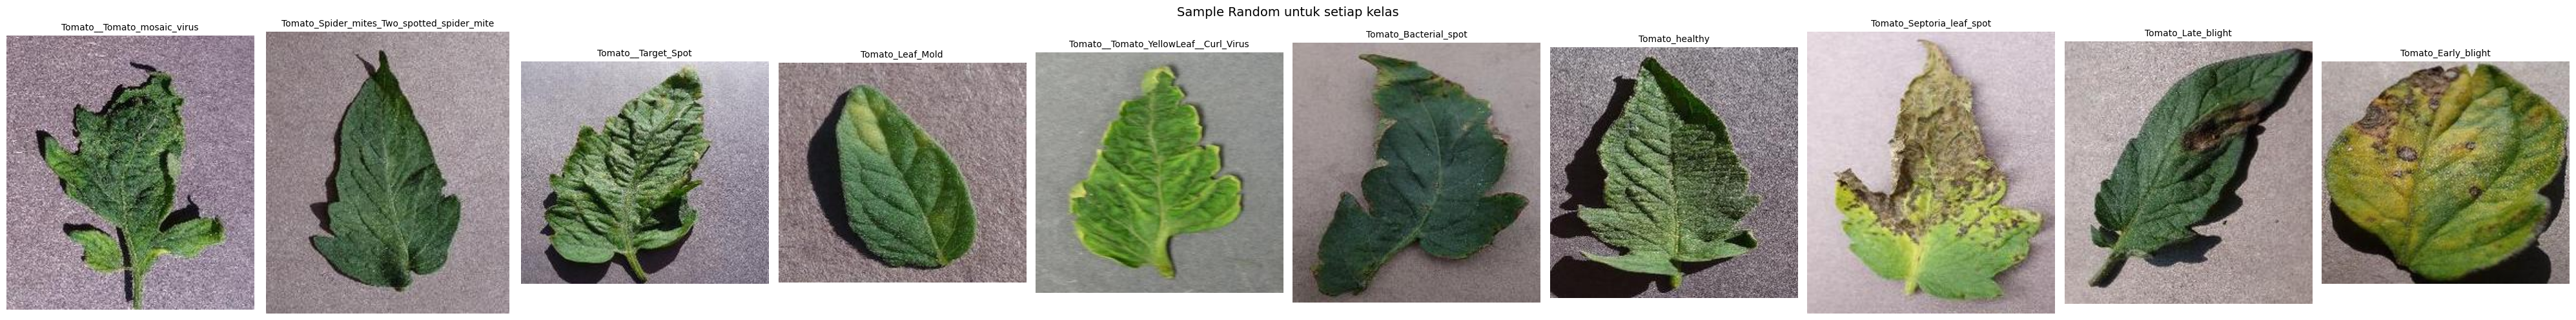

In [14]:
def show_sample_images(dataset_path):
    """
    menampilkan salah satu gambar random dari setiap kelas.
    """
    sample_images = {}

    for root, _, files in os.walk(dataset_path):
        if files:
            class_name = os.path.basename(root)
            chosen_image = random.choice(files)
            sample_images[class_name] = os.path.join(root, chosen_image)

    num_classes = len(sample_images)
    fig, axes = plt.subplots(1, num_classes, figsize=(4 * num_classes, 5))
    fig.suptitle("Sample Random untuk setiap kelas", fontsize=14)

    # jika hanya satu subplot, jadikan list agar bisa di-iterasi
    if num_classes == 1:
        axes = [axes]

    # menampilkan setiap gambar dengan label kelasnya
    for ax, (class_name, image_path) in zip(axes, sample_images.items()):
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title(class_name, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# sesuaikan dataset
dataset_path = "/content/dataset-tomato"
show_sample_images(dataset_path)


**SPLIT DATASET**

minimal dataset yg dibutuhkan adalah 10.000, jadi akan dipilih 5 kelas saja

In [15]:
def delete_unwanted_folders(dataset_path, keep_folders=['Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot','Tomato_healthy','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato_Septoria_leaf_spot']):
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path) and item not in keep_folders:
            shutil.rmtree(item_path)
            print(f"Menghapus folder: {item_path}")

# sesuaikan path folder
dataset_path = "/content/dataset-tomato"

delete_unwanted_folders(dataset_path)

Menghapus folder: /content/dataset-tomato/Tomato__Tomato_mosaic_virus
Menghapus folder: /content/dataset-tomato/Tomato__Target_Spot
Menghapus folder: /content/dataset-tomato/Tomato_Leaf_Mold
Menghapus folder: /content/dataset-tomato/Tomato_Late_blight
Menghapus folder: /content/dataset-tomato/Tomato_Early_blight


In [22]:
# membagi dataset dengan rasio 70:15:15

def split_dataset_3way(dataset_path, train_ratio=0.8, val_ratio=0.15):
    # path untuk dataset training dan testing
    train_path = os.path.join(dataset_path, 'train')
    val_path = os.path.join(dataset_path, 'val')
    test_path = os.path.join(dataset_path, 'test')


    # membuat folder train, val, test
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for root, dirs, files in os.walk(dataset_path):
        if root == dataset_path:
            continue

        class_name = os.path.basename(root)
        if class_name in ['train','val', 'test']:
            continue

        # membuat folder kelas di dalam train dan test
        train_class_path = os.path.join(train_path, class_name)
        val_class_path = os.path.join(val_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # shuffle files dan hitung pembagian
        random.shuffle(files)
        total = len(files)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        train_files = files[:train_end]
        val_files = files[train_end:val_end]
        test_files = files[val_end:]

        for file in train_files:
            shutil.move(os.path.join(root, file), os.path.join(train_class_path, file))

        for file in val_files:
            shutil.move(os.path.join(root, file), os.path.join(val_class_path, file))

        for file in test_files:
            shutil.move(os.path.join(root, file), os.path.join(test_class_path, file))

# path ke folder utama
dataset_path = "/content/dataset-tomato"

split_dataset_3way(dataset_path)

In [23]:
def delete_directory_unwanted(dataset_path, keep_folders=['train','val','test']):
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path) and item not in keep_folders:
            shutil.rmtree(item_path)
            print(f"Menghapus folder: {item_path}")

# sesuaikan path folder
dataset_path = "/content/dataset-tomato"

delete_directory_unwanted(dataset_path)

## Modelling

In [25]:
def prepare_image_generator(dataset_path, img_size=(130, 130), batch_size=32):
    train_path = os.path.join(dataset_path, 'train')
    val_path = os.path.join(dataset_path, 'val')
    test_path = os.path.join(dataset_path, 'test')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # rescale untuk data val dan test
    datagen_test = ImageDataGenerator(rescale=1./255)


    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = datagen_test.flow_from_directory(
        val_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = datagen_test.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator,val_generator, test_generator

# sesuaikan path
dataset_path = "/content/dataset-tomato"

train_generator,val_generator, test_generator = prepare_image_generator(dataset_path)

# cek kelas yg ada di dataset
class_indices = train_generator.class_indices
print(class_indices)

Found 5108 images belonging to 5 classes.
Found 1017 images belonging to 5 classes.
Found 350 images belonging to 5 classes.
{'Tomato_Bacterial_spot': 0, 'Tomato_Septoria_leaf_spot': 1, 'Tomato_Spider_mites_Two_spotted_spider_mite': 2, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3, 'Tomato_healthy': 4}


In [28]:
# menggunakan transfer learning dan MobileNetV2

pretrained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(130,130,3))

for layer in pretrained_model.layers:
    layer.trainable = False

model = Sequential()

model.add(pretrained_model)

# menambahkan Conv2D and Pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten(name="flatten"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dense(5, activation='softmax'))

<ipython-input-28-13b5775f1a2f>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(130,130,3))


In [29]:
# menggunakan transfer learning based on MobileNetV2

def create_tomato_disease_classifier(input_dimensions=(130, 130, 3), num_classes=5):

   # load pre-trained MobileNetV2
   base_network = MobileNetV2(
       weights="imagenet",
       include_top=False,
       input_shape=input_dimensions
   )

   # freeze model layer supaya tidak perlu melatih ulang
   for layer in base_network.layers:
       layer.trainable = False

   classifier = Sequential(name="TomatoDiseaseClassifier")

   # tambahkan jaringan dasar
   classifier.add(base_network)

   # tambahkan kustom layer untuk feature extraction dan klasifikasi
   classifier.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
   classifier.add(MaxPooling2D(pool_size=(2, 2)))
   classifier.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
   classifier.add(MaxPooling2D(pool_size=(2, 2)))

   # ratakan dan tambah layer yg terhubung sepenuhnya
   classifier.add(Flatten(name="flatten_features"))
   classifier.add(Dropout(rate=0.5))
   classifier.add(Dense(128, activation="relu"))
   classifier.add(Dense(num_classes, activation='softmax'))

   return classifier

# buat model
tomato_classifier = create_tomato_disease_classifier()

<ipython-input-29-909e5f556a54>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_network = MobileNetV2(


**COMPILE MODEL**

In [33]:
# melakukan kompilasi model dengan optimizer Adam, loss categorical cross-entropy, dan metrik evaluasi.

def compile_model(model, learning_rate=0.001):

    # inisialisasi optimizer Adam dengan learning rate yang ditentukan
    optimizer = Adam(learning_rate=learning_rate)

    # compile model dengan konfigurasi yang diinginkan
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )

    return model

# compile model yang telah dibuat sebelumnya
tomato_classifier = compile_model(tomato_classifier)

# tampilkan ringkasan model
tomato_classifier.summary()

Model: "TomatoDiseaseClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_features (Flatten)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,654,117 (10.12 MB)

 Trainable params: 396,133 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
# membuat callback early stopping yg memonitor val_accuracy

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,                   # berhenti jika tidak ada peningkatan dalam 5 epoch
    restore_best_weights=True,
    mode="max",
    verbose=1
)


In [31]:
# membuat callback model checkpoint yg memonitor val_accuracy
checkpoint_cb = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

In [34]:
# training model
num_epochs = 15

W = tomato_classifier.fit(train_generator,
              epochs=num_epochs,
              validation_data=val_generator,
              callbacks=[earlystop_cb, checkpoint_cb],
              verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5914 - loss: 1.0614 - precision: 0.6818 - recall: 0.4634
Epoch 1: val_accuracy improved from -inf to 0.88594, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 51s 242ms/step - accuracy: 0.5923 - loss: 1.0591 - precision: 0.6826 - recall: 0.4646 - val_accuracy: 0.8859 - val_loss: 0.3069 - val_precision: 0.9004 - val_recall: 0.8800
Epoch 2/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8738 - loss: 0.3796 - precision: 0.9000 - recall: 0.8466
Epoch 2: val_accuracy improved from 0.88594 to 0.91347, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.8739 - loss: 0.3793 - precision: 0.9001 - recall: 0.8467 - val_accuracy: 0.9135 - val_loss: 0.2141 - val_precision: 0.9266 - val_recall: 0.9056
Epoch 3/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9069 - loss: 0.2746 - precision: 0.9256 - recall: 0.8930
Epoch 3: val_accuracy improved from 0.91347 to 0.93707, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 43s 178ms/step - accuracy: 0.9069 - loss: 0.2746 - precision: 0.9256 - recall: 0.8930 - val_accuracy: 0.9371 - val_loss: 0.2063 - val_precision: 0.9401 - val_recall: 0.9253
Epoch 4/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9336 - loss: 0.2032 - precision: 0.9425 - recall: 0.9195
Epoch 4: val_accuracy did not improve from 0.93707
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.9336 - loss: 0.2033 - precision: 0.9424 - recall: 0.9195 - val_accuracy: 0.9194 - val_loss: 0.2712 - val_precision: 0.9245 - val_recall: 0.9145
Epoch 5/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9287 - loss: 0.2229 - precision: 0.9343 - recall: 0.9215
Epoch 5: val_accuracy improved from 0.93707 to 0.94297, saving model to best_model.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.9287 - loss: 0.2228 - precision: 0.9343 - recall: 0.9215 - val_accuracy: 0.9430 - val_loss: 0.1539 - val_precision: 0.9485 - val_recall: 0.9410
Epoch 6/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9450 - loss: 0.1709 - precision: 0.9538 - recall: 0.9362
Epoch 6: val_accuracy did not improve from 0.94297
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.9450 - loss: 0.1710 - precision: 0.9538 - recall: 0.9362 - val_accuracy: 0.9410 - val_loss: 0.1803 - val_precision: 0.9437 - val_recall: 0.9390
Epoch 7/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9475 - loss: 0.1666 - precision: 0.9576 - recall: 0.9414
Epoch 7: val_accuracy did not improve from 0.94297
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.9475 - loss: 0.1667 - precision: 0.9575 - recall: 0.9414 - val_accuracy: 0.9027 - val_loss: 0.2827 - val_precision: 0.9170 - val_recall: 0.8909
Epoch 8/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s

160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - accuracy: 0.9514 - loss: 0.1630 - precision: 0.9572 - recall: 0.9445 - val_accuracy: 0.9597 - val_loss: 0.1327 - val_precision: 0.9622 - val_recall: 0.9499
Epoch 10/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9594 - loss: 0.1416 - precision: 0.9624 - recall: 0.9506
Epoch 10: val_accuracy did not improve from 0.95969
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.9594 - loss: 0.1416 - precision: 0.9624 - recall: 0.9506 - val_accuracy: 0.9174 - val_loss: 0.3045 - val_precision: 0.9196 - val_recall: 0.9115
Epoch 11/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9591 - loss: 0.1209 - precision: 0.9655 - recall: 0.9556
Epoch 11: val_accuracy did not improve from 0.95969
160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step - accuracy: 0.9591 - loss: 0.1209 - precision: 0.9655 - recall: 0.9556 - val_accuracy: 0.9361 - val_loss: 0.1770 - val_precision: 0.9431 - val_recall: 0.9292
Epoch 12/15
160/160 ━━━━━━━━━━━━━━━━━━

## Evaluasi dan Visualisasi

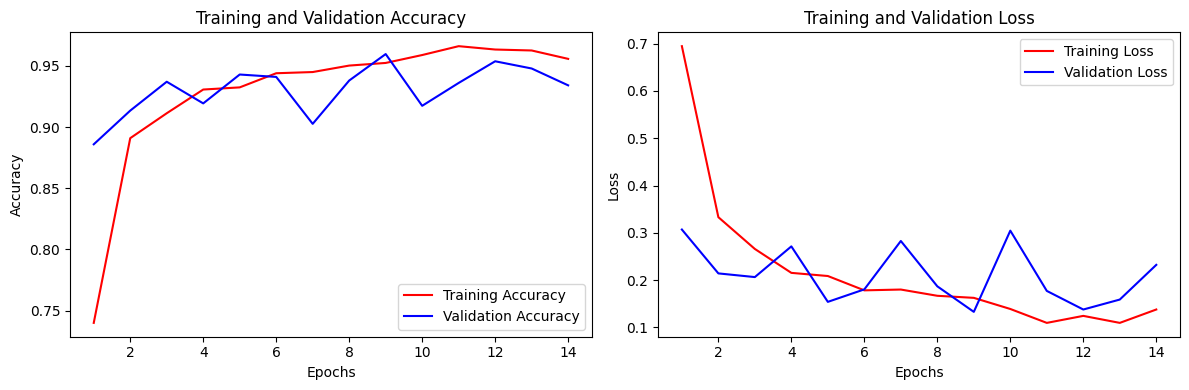

In [35]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# sesuaikan fungsi dengan history
plot_training_history(W)


## Konversi Model

In [36]:
def save_all_formats(model, base_name='model_tomato'):
    # save ke .keras (native keras v3 format)
    keras_path = f'{base_name}.keras'
    model.save(keras_path)
    print(f'[✔] Saved as .keras -> {keras_path}')

    # save ke .h5
    h5_path = f'{base_name}.h5'
    model.save(h5_path)
    print(f' Saved as .h5 -> {h5_path}')

    # save ke SavedModel
    saved_model_dir = f'{base_name}_saved_model'
    model.export(saved_model_dir)
    print(f' Saved as SavedModel -> {saved_model_dir}/')

    # konversi ke TFLite
    tflite_path = f'{base_name}.tflite'
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
    tflite_model = converter.convert()
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print(f'Saved as TFLite -> {tflite_path}')

    # konversi ke TensorFlow.js
    tfjs_dir = f'{base_name}_tfjs'
    try:
        subprocess.run([
            'tensorflowjs_converter',
            '--input_format=keras',
            h5_path,
            tfjs_dir
        ], check=True)
        print(f' Converted to TensorFlow.js -> {tfjs_dir}/')
    except Exception as e:
        print(' TFJS conversion failed. Make sure tensorflowjs is installed with: pip install tensorflowjs')
        print(W)


In [37]:
save_all_formats(model, base_name='tomato_classifier')

[✔] Saved as .keras -> tomato_classifier.keras
 Saved as .h5 -> tomato_classifier.h5
Saved artifact at 'tomato_classifier_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 130, 130, 3), dtype=tf.float32, name='keras_tensor_552')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140061402282512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140061309665936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140061309666512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140061402283088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140061309665552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140061309667664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140061309668048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140061309668432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140061309668240: TensorSpec(shape=(), dtype=tf.resou

In [ ]:
!pip freeze > requirements.txt